# Playing Golf with RL

## Explaining the problem

The golf field is divided into $L \times L$ squares. The ball and the flag (representing the hole where the ball has to be put by the player) start in randomly chosen squares. The algorithm should learn how to move the ball from the initial position to the flag using the minimum number of plays.

The only physical restriction in this simplified version of the game is: each play can only move the ball to its neighborhood.


## Thinking about the problem

In this game, we can model a **state** as a pair formed by the ball and flag positions (representing the hole), where each one is defined by a point in $\mathbb{N}^{2}$, representing a position in the field (see pictures and GIFs below for a better understanding).

For a field of size $L$, a position $p \in \{ (1,1), (1, 2), ..., (L, L) \} \subset \mathbb{N}^{2}$.

Hence, there are $L^2$ possible positions for the ball and, analogous, for the flag. Therefore:

$$|S| = L^4 $$

From the description of the problem, we propose an action set with 8 actions: North (N), Northeast (NE), East (E), Southeast (SE), South (S), Southwest (SW), West (W), and Northwest (NW) - in which all actions can be taken in any state.

In this case, the number of pairs state-action is given by:

$$|StAc| = |S||A| = 8L^4$$

For $L=7$, which we adopt in this project, we have $|S| = 7^4 = 2401$ and $|StAc| = 19208$ state-action pairs.

We do not adopt partial rewards. The agent is rewarded only in the states where the ball position is equal to the flag position, i.e. in the terminal states. In a first moment, we define the reward as 100, however this will become a hyperparameter to be optimized later on.

 \begin{equation}
    R=
    \begin{cases}
      100, & \text{if}\ \text{ball position} = \text{flag position} \\
      0, & \text{otherwise}
    \end{cases}
  \end{equation}

# RL choices

In this project, we use an on-policy first-visit MC algorithm for $\epsilon$-soft policies and the SARSA algorithm, both as described in Sutton \& Barto (2015).

The former, as the name suggests, is an on-policy strategy (its behaviour policy during training is derived from the same policy which we aim to approximate of the optimal policy), as well as SARSA.

While SARSA is clearly value-based (we try to estimate $Q$, not the optimal policy), it seems to me that our MC strategy is a mix of value-based and policy-based, as both quantities are outputs of the algorithm (I am not sure of this affirmation).

In terms of exploration method, we always choose $\epsilon$-greedy. This is mostly due to its simplicity. We see no reason to choose other method (such as UCB) here. It seems to work quite nice, as we see in the animations below.

Lastly, our first method uses MC-learning while SARSA uses TD-learning.

Intuitively, my first impression was that as we have relatively short episodes (and always finite) in this problem (specially considering the restriction in the number of plays), Monte Carlo methods should work quite fine. However, what I observe in this experiement is that, for the same number of learning games, the TD-learning seems to learn a better policy (see results in later sections).


In [ ]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import matplotlib.animation as animation
import copy

In [ ]:
#Packages for Gif
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

# Running the code

Make sure to change to a local folder in your personal Drive (marked with *#CHANGE TO LOCAL DIRECTORY*).

In [ ]:
#Grant access to GDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#CHANGE TO LOCAL DIRECTORY
path = '/content/drive/MyDrive/Colab Notebooks/Reinforcement Learning/'

## Main hyperparameters

We choose the hyperparameters below "by hand". However, as we have mentioned before, these will be optimized for faster convergence of the algorithms which we are going to test in later sections of this project.

The field length and a fixed action space with 8 actions for any state come naturally from the description of the problem. The reward was explained in the section *Thinking about the problem*.

We use a discount factor of 0.9. This allows the learning process to understand that we want to reach the flag as fast as possible. The smaller the factor, the more incentive we have to reach it faster (with a trade-off in terms of convergence time).

We set the $\epsilon$ parameter for $\epsilon$-greedy policies (the sole exploration method used in the project) to 10%.

Finally, we set the learning rate of SARSA to 5% at a first moment.

In [ ]:
#MAIN HYPERPARAMETERS

#Field length
field_len = 7

#Actions space
action_space = ['north',
           'northeast',
           'east',
           'southeast',
           'south',
           'southwest',
           'west',
           'northwest'
           ]

#Total reward received when player scores
R = 100

#Discount factor
gamma = 0.9

#Epsilon for epsilon-soft policies
eps = 0.1

#Alpha for SARSA
alpha = 0.05

We set below the number of games during training for each one of our methods.

In [ ]:
#Some useful parameters
nb_games_learning_MC = 50000
nb_games_learning_SARSA = 30000

## Displaying the game

We built a graphical interface for the game. The blue circle represents the ball, while the orange triangle represents the flag (or the hole).
For starting a game, we randomly select positions for the ball and the flag, encompassing an initial state. The picture below shows an example of this initialization.

In [ ]:
def initialState(field_len):

    #Randomly choose ball position
    ball_x, ball_y = random.randint(0, field_len-1), random.randint(0, field_len-1)
    ball_position = [ball_x, ball_y]

    #Randomly choose flag position
    flag_x, flag_y = random.randint(0, field_len-1), random.randint(0, field_len-1)
    flag_position = [flag_x, flag_y]

    return ball_position, flag_position

In [ ]:
def display_field(ax, ball_position, flag_position, field_len):

    #Dsiplay ball and flag
    ax.scatter(ball_position[0] - 0.5 + 1, ball_position[1] - 0.5 + 1, marker='o')
    ax.scatter(flag_position[0] - 0.5 + 1, flag_position[1] - 0.5 + 1, marker='>')

    #Set axis max and min values
    ax.set_xlim(0, field_len)
    ax.set_ylim(0, field_len)

    #Major ticks every 1, minor ticks every 1
    major_ticks = np.arange(0, field_len, 1)
    minor_ticks = np.arange(0, field_len, 1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)

    # And a corresponding grid
    ax.grid(which='both')

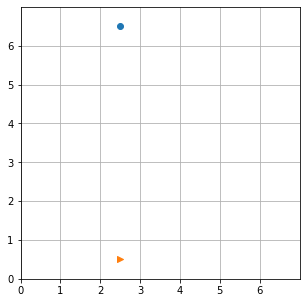

In [ ]:
#Initial configuration of field
fig, ax = plt.subplots(figsize=(5,5))

ball_position_simulation, flag_position_simulation = initialState(field_len)
display_field(ax, ball_position_simulation, flag_position_simulation, field_len) #Display field

#Create copy of the initial position of the ball
ball_position_simulation_start = ball_position_simulation.copy()

The function *play* below changes the position of the ball based on the selected action. We recall that if the action would make the ball leave the field, it stays in the same position.

As we are using a discount factor for total rewards, this represents a type of punishment for the agent, representing the fact that in real life the player would have to waste a round/time looking for the ball and bringing it back to the same position as before.

In [ ]:
def play(ball_position, field_len, action):

    #Get ball positions
    ball_x, ball_y = ball_position[0], ball_position[1]

    #This action is only needed for the animation
    if action == 'stop':
        return

    #If ball goes out of field, stay in the same position
    if (
          ('north' in action and (ball_y + 1 >= field_len)) or
          ('south' in action and (ball_y - 1 < 0)) or
          ('east' in action and (ball_x + 1 >= field_len)) or
          ('west' in action and (ball_x - 1 < 0))
       ):
          return

    #If inside of field, play
    if 'north' in action:
        ball_position[1] += 1
    elif 'south' in action:
        ball_position[1] -= 1

    if 'east' in action:
        ball_position[0] += 1
    elif 'west' in action:
        ball_position[0] -= 1

In [ ]:
#Randomly select a few actions
N = 3
S = len(action_space)
actions = ['stop'] #Always start with stop for animation purposes
for i in range(N):
    actions.append(action_space[random.randint(0, S-1)])

#Print selected actions
actions[1:]

['northwest', 'southwest', 'west']

In [ ]:
def update(i, ball_position_animation,flag_position_animation,field_len, actions):
    ax.clear() #Clear axis
    play(ball_position_animation, field_len, actions[i]) #Play
    display_field(ax, ball_position_animation, flag_position_animation, field_len) #Display field

def gifCreation(path, name_file, frames, ball_position_animation, flag_position_animation, field_len, actions):

    #Realize actions and save GIF
    ani = animation.FuncAnimation(fig, update, fargs=(ball_position_animation,flag_position_animation,field_len,actions,), frames=frames, interval=1000)
    ani.save(path+'/' + name_file + '.gif', writer='pillow')

def gifShow(path, name_file):

    gifPath = path + '/' + name_file + '.gif'

    # Display GIF in Jupyter, CoLab, IPython
    with open(gifPath,'rb') as f:
        im = display.Image(data=f.read(), format='png')
    return im

The GIFs presented throughout the report represent the game graphically. We see the ball moving according to the actions selected by a certain algorithm (in the case below, we just select three random actions).

When in the edges, the ball may take more time at a certain position. When it happens, this indicates that the action would have made the ball leave the field, as explained in the previous paragraph.

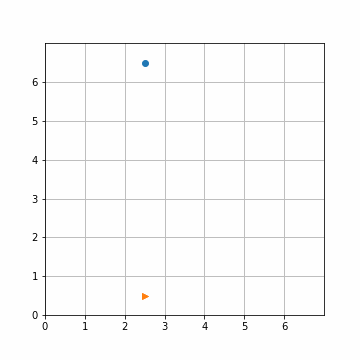

In [ ]:
#############
# GIF BLOCK #
#############

#Number of frames
frames = N+1
name_file = 'scatter'
gifCreation(path, name_file, frames, ball_position_simulation, flag_position_simulation, field_len, actions)
gif = gifShow(path, name_file)
gif

In [ ]:
def game_score(ball_position, flag_position):
    return ball_position[0]==flag_position[0] and ball_position[1]==flag_position[1]

def game_limit(n, field_len):
    return n > 3*field_len

def discount_factor(gamma, n):
    return gamma**n

def reward(R, ball_position, flag_position, gamma, n):
    if game_score(ball_position, flag_position):
        return discount_factor(gamma, n)*R

    return 0

## State and action classes

We write Python classes for states and actions and add some useful methods to run our algorithms.

In [ ]:
class State:
    def __init__(self, ball_position, flag_position):
        self.ball = ball_position
        self.flag = flag_position

    def nextState(self, action):
        play(self.ball, field_len, action)

    def nextAction(self, policy):

        b = PositionToIndex[(self.ball[0], self.ball[1])]
        f = PositionToIndex[(self.flag[0], self.flag[1])]

        distProb = policy[b][f]
        return action_space[np.random.choice(range(len(action_space)), p=distProb)]


class Episode:
    def __init__(self, policy, state):
        self.policy = policy
        self.state = state
        self.episode = [state]
        self.actions = []
        self.future_rewards = []

        #self.Q = Q
        #self.returns = [ [ [ [] for i in range(len(action_space)) ] for j in range(field_len**2) ] for k in range(field_len**2) ]

    def generateEpisode(self, state, R, gamma):

        nb_episode = 1
        while(not game_limit(nb_episode, field_len) and not game_score(self.state.ball, self.state.flag)):

            nb_episode += 1

            action = self.state.nextAction(self.policy)
            self.actions.append(action)
            self.state.nextState(action)
            self.episode.append(copy.deepcopy(self.state))

        #Compute rewards looking back
        self.rewardsInEpisode(R, gamma)

    def rewardsInEpisode(self, R, gamma):
        for i, s in enumerate(reversed(self.episode)):

            if i == 0:
                self.future_rewards.append(reward(R, s.ball, s.flag, gamma, i))
            else:
                self.future_rewards.append(self.future_rewards[i-1]*gamma)

        self.future_rewards = list(reversed(self.future_rewards))


class StateAction:
    def __init__(self, state_sequence, action_sequence):
        self.stateSeq = state_sequence
        self.actionSeq = action_sequence

In [ ]:
#Create dictionaries to help in navigating positions in the board and positions in the tensor
IndexToPosition = {}

incr = 0
for i in range(field_len):
    for j in range(field_len):
        IndexToPosition[incr] = (i, j)
        incr += 1

PositionToIndex = {value : key for (key, value) in IndexToPosition.items()}

ActionToIndex = {}
for i, act in enumerate(action_space):
    ActionToIndex[act] = i

## The optimal policy

By the geometry of the game, a human could instantly infer an optimal policy for this game (i.e. a deterministic policy which takes the least amount of steps).

It suffices to play diagonally until you reach the same row or column of the hole, and then play straight to the flag.

The function below computes how many plays this optimal strategy would take. We call it the minimal quantity of steps.

In [ ]:
def minimalQtySteps(state):

    #Get positions
    ball_pos = state.ball
    flag_pos = state.flag

    return max(abs(ball_pos[0] - flag_pos[0]), abs(ball_pos[1] - flag_pos[1]))

## On-policy Monte Carlo

We implement the on-policy first-visit MC algorithm for $\epsilon$-soft policies presented in Sutton \& Barton (2015).

In [ ]:
#On-policy first-visit MC control algorithm for ε-soft policies
def OnPolicyMC(nb_episodes, R, gamma, Q, Returns, policy):

    #Policy norm history vector
    policy_history = []

    #Diff number of steps history
    diff = []

    for ep in range(nb_episodes): #Repeat forever (it does NOT make sense to measure convergence using new-old)

        #Random initial position for the ball and the flag
        ball_position, flag_position = initialState(field_len)

        #Create an initial state object
        initial_state = State(ball_position, flag_position)

        #Minimum number of steps needed
        nb_optimal = minimalQtySteps(initial_state)

        #Generate episode
        episode = Episode(policy, initial_state)
        episode.generateEpisode(initial_state, R, gamma)

        #Number of steps with policy
        diff.append(len(episode.actions) - nb_optimal)

        alreadyAppeared = []
        for i, s in enumerate(episode.episode):
            if i < len(episode.actions):
                if s not in alreadyAppeared:

                    #G = sum(episode.future_rewards[(i+1):])
                    G = episode.future_rewards[i]

                    index_ball = PositionToIndex[(s.ball[0], s.ball[1])]
                    index_flag = PositionToIndex[(s.flag[0], s.flag[1])]
                    index_action = ActionToIndex[episode.actions[i]]

                    Returns[index_ball][index_flag][index_action].append(G)
                    Q[index_ball][index_flag][index_action] = np.mean(Returns[index_ball][index_flag][index_action])

                    alreadyAppeared.append(s)

        #Old policy
        old_policy = policy.copy()

        for i, s in enumerate(episode.episode):

            index_ball = PositionToIndex[(s.ball[0], s.ball[1])]
            index_flag = PositionToIndex[(s.flag[0], s.flag[1])]

            #action_max = np.argmax(Q[index_ball][index_flag])
            action_max = np.random.choice(np.where(Q[index_ball][index_flag] == Q[index_ball][index_flag].max())[0]) #Random choice in case of draw (it avoids returning the action North all the time, which is the first one)

            for act in range(len(action_space)):
                if act == action_max:
                    policy[index_ball][index_flag][act] = 1 - eps + eps/len(action_space)
                else:
                    policy[index_ball][index_flag][act] = eps/len(action_space)

        #Compute tensor norm as proxy of convergence
        policy_history.append(np.linalg.norm(policy))

    return policy_history, diff

In [ ]:
#State-action value matrix (we will model it as a tensor to ease visualization)
#First position indicates the ball position, second the flag position and the third, the possible action
Q = np.zeros((field_len**2, field_len**2, len(action_space)))

#Policy conditional to state
policy_MC = np.random.rand(field_len**2, field_len**2, len(action_space))
for i in range(policy_MC.shape[0]):
    for j in range(policy_MC.shape[1]):
        policy_MC[i][j] = policy_MC[i][j]/np.sum(policy_MC[i][j]) #Normalize

#Returns (list of lists of lists)
Returns = [ [ [ [] for i in range(len(action_space)) ] for j in range(field_len**2) ] for k in range(field_len**2) ]

#Difference of steps policy to optimal history
diff = []

Training the policy for 50k games takes roughly 2min40s in Google Colab.

In [ ]:
%%time

#Train policy
policy_history_MC, diff = OnPolicyMC(nb_games_learning_MC, R, gamma, Q, Returns, policy_MC)

CPU times: user 1min 30s, sys: 1min 11s, total: 2min 41s
Wall time: 1min 22s


We use the Frobenius norm of the policy vector as a proxy of convergence. In the chart below, we see that the norm increases drastically during the first thousand games and then it roughly stabilizes after 5000 games.

**PS: Actually, inferring convergence from the norm is not ideal. I remarked this after seeing the chart on the difference of steps of our policy to the optimal one. Clearly, the policy is still improving, although the norm remains almost constant.**

Text(0.5, 0, 'Number of games during learning')

Text(0, 0.5, 'Frobenius norm of policy tensor')

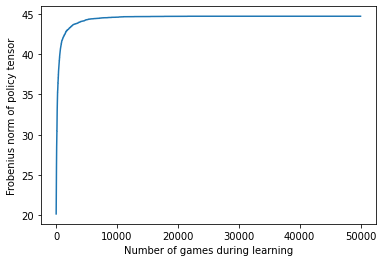

In [ ]:
#Plot Frobenius norm of policy tensors as a proxy of convergence
plt.plot(policy_history_MC)
plt.xlabel('Number of games during learning')
plt.ylabel('Frobenius norm of policy tensor')

We see that as time passes, our policy becomes closer to the optimal policy in terms of reducing the gap of the number of steps to reach the flag.

Text(0.5, 0, 'Number of games during learning')

Text(0, 0.5, 'Diff btween number of actions using policy and optimal policy')

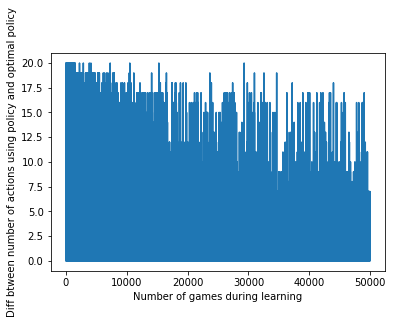

In [ ]:
#Plot difference of steps
plt.plot(diff)
plt.xlabel('Number of games during learning')
plt.ylabel('Diff btween number of actions using policy and optimal policy')

In [ ]:
def simulate(policy, name_file, verb):

    #Randomly select initial positions
    ball_pos, flag_pos = initialState(field_len)
    ball_pos_initial = ball_pos.copy()

    #Create an initial state object
    initial_state = State(ball_pos, flag_pos)

    #Generate episode
    episode = Episode(policy, initial_state)
    episode.generateEpisode(initial_state, R, gamma)

    #Print total reward
    if verb:
        print('Total reward', episode.future_rewards[0])

    #Create a vector for actions beginning with stop action (for animation)
    actions = ['stop'] #Always start with stop for animation purposes
    for i in range(len(episode.actions)):
        actions.append(episode.actions[i])

    #Number of frames
    frames = len(actions)

    n_f = name_file
    gifCreation(path, n_f, frames, ball_pos_initial, flag_pos, field_len, actions)
    gif = gifShow(path, name_file)
    return gif

**Simulating the game with the obtained policy**: the animation below shows a simulation of a game with the policy obtained from the MC algorithm, in which the initial state is randomly selected.

**The user can run the cell below as many times as she/he wants to see how the policy behaves in multiple initial scenarios.**

Total reward 59.049000000000014


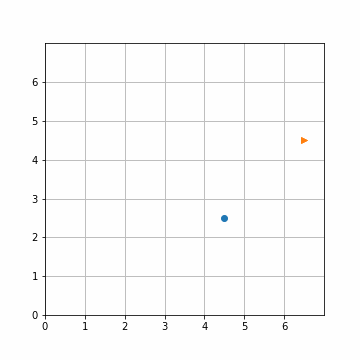

In [ ]:
#Simulate game with optimal policy
gif = simulate(policy_MC, 'simulation_MonteCarlo', True)
gif

## SARSA

We implement the SARSA algorithm presented in Sutton \& Barton (2015). Our final policy is greedy with respect to the estimated $Q$.

In [ ]:
#State-action value matrix (we will model it as a tensor to ease visualization)
#First position indicates the ball position, second the flag position and the third, the possible action
Q = np.zeros((field_len**2, field_len**2, len(action_space)))

#Policy conditional to state
policy_SARSA = np.random.rand(field_len**2, field_len**2, len(action_space))
for i in range(policy_SARSA.shape[0]):
    for j in range(policy_SARSA.shape[1]):
        policy_SARSA[i][j] = policy_SARSA[i][j]/np.sum(policy_SARSA[i][j]) #Normalize

#Policy for simulation
policy_simulation = np.random.rand(field_len**2, field_len**2, len(action_space))

In [ ]:
def eps_greedy_policy_update(policy, Q, state):

    index_ball = PositionToIndex[(state.ball[0], state.ball[1])]
    index_flag = PositionToIndex[(state.flag[0], state.flag[1])]

    #ε-soft policies
    action_max = np.random.choice(np.where(Q[index_ball][index_flag] == Q[index_ball][index_flag].max())[0])
    for act in range(len(action_space)):
        if act == action_max:
            policy[index_ball][index_flag][act] = 1 - eps + eps/len(action_space)
        else:
            policy[index_ball][index_flag][act] = eps/len(action_space)

In [ ]:
def policyFromSarsa(Q, policy):

    for s1 in range(Q.shape[0]):
        for s2 in range(Q.shape[1]):
            action_max = np.random.choice(np.where(Q[s1][s2] == Q[s1][s2].max())[0])

            for act in range(len(action_space)):
                if act == action_max:
                    policy[s1][s2][act] = 1
                else:
                    policy[s1][s2][act] = 0

In [ ]:
def Sarsa(nb_episodes, R, gamma, Q, policy):

    #Policy norm history vector
    Q_history = []

    #Difference of number of actions (policy-optimal) needed
    diff_actions_needed_history = []

    for ep in range(nb_episodes): #Repeat forever (it does NOT make sense to measure convergence using new-old)

        #Random initial position for the ball and the flag
        ball_position, flag_position = initialState(field_len)
        ball_position_initial, flag_position_initial = ball_position.copy(), flag_position.copy()

        #Create an initial state object
        state = State(ball_position, flag_position)

        #Compute optimal number of actions needed
        nb_actions_optimal = minimalQtySteps(state)

        #Update policy (eps-greedy )
        eps_greedy_policy_update(policy, Q, state)

        #Select action based on this policy
        action = state.nextAction(policy)

        #While episode does not end
        step = 1
        while(not game_limit(step, field_len) and not game_score(state.ball, state.flag)):

            #Make a copy of previous state
            state_previous = copy.deepcopy(state)

            #Go to next state using eps-greedy policy
            state.nextState(action) #Go to next state
            rew = reward(R, state.ball, state.flag, 1, 0) #Get no-discounted reward

            #Update policy
            eps_greedy_policy_update(policy, Q, state)

            #Select next action
            next_action = state.nextAction(policy)

            #Select index
            index_ball_previous = PositionToIndex[(state_previous.ball[0], state_previous.ball[1])]
            index_flag_previous = PositionToIndex[(state_previous.flag[0], state_previous.flag[1])]

            index_ball = PositionToIndex[(state.ball[0], state.ball[1])]
            index_flag = PositionToIndex[(state.flag[0], state.flag[1])]

            index_action = ActionToIndex[action]
            index_action_next = ActionToIndex[next_action]

            #Update Q
            Q[index_ball_previous][index_flag_previous][index_action] = Q[index_ball_previous][index_flag_previous][index_action] + alpha*(rew + gamma*Q[index_ball][index_flag][index_action_next] - Q[index_ball_previous][index_flag_previous][index_action])

            #Update action as algorithm demands (state already updated)
            action = next_action

            #Increment step
            step += 1

        #Compute tensor norm as proxy of convergence
        Q_history.append(np.linalg.norm(Q))

        #Number of needed steps in the episode (with greedy policy)
        if ep % 100 == 0:
            state_initial = State(ball_position_initial, flag_position_initial)
            policyFromSarsa(Q, policy_simulation)
            #Generate episode
            episode = Episode(policy_simulation, state_initial)
            episode.generateEpisode(state_initial, R, gamma)
            nb_actions_policy = len(episode.actions)

            #Append to history
            diff_actions_needed_history.append(nb_actions_policy - nb_actions_optimal)

    return Q_history, diff_actions_needed_history

Training the policy for 30k games takes roughly 2min50s in Google Colab.

In [ ]:
%%time

#Train policy
Q_history, diff_actions = Sarsa(nb_games_learning_SARSA, R, gamma, Q, policy_SARSA)

CPU times: user 1min 35s, sys: 1min 13s, total: 2min 48s
Wall time: 1min 28s


Text(0.5, 0, 'Number of games during learning')

Text(0, 0.5, 'Frobenius norm of Q tensor')

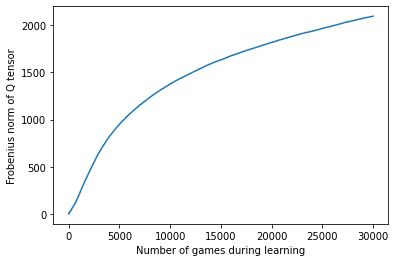

In [ ]:
#Plot Frobenius norm of Q tensors as a proxy of convergence
plt.plot(Q_history)
plt.xlabel('Number of games during learning')
plt.ylabel('Frobenius norm of Q tensor')

**An interesting result**: if we compare this chart with the analogous one in the MC section, we see that our policy derived from SARSA gets much closer to the optimal policy (and much faster, since we learnt with 20k less games)!

Text(0.5, 0, 'Number of games during learning')

Text(0, 0.5, 'Diff btween number of actions using policy and optimal policy')

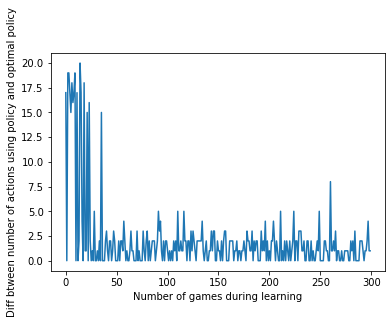

In [ ]:
plt.plot(diff_actions)
plt.xlabel('Number of games during learning')
plt.ylabel('Diff btween number of actions using policy and optimal policy')

In [ ]:
#Get greedy policy from Q
policyFromSarsa(Q, policy_SARSA)

**Simulating the game with the obtained policy**: the animation below shows a simulation of a game with the policy obtained from the SARSA algorithm, in which the initial state is randomly selected.

**The user can run the cell below as many times as she/he wants to see how the policy behaves in multiple initial scenarios.**

Total reward 59.049000000000014


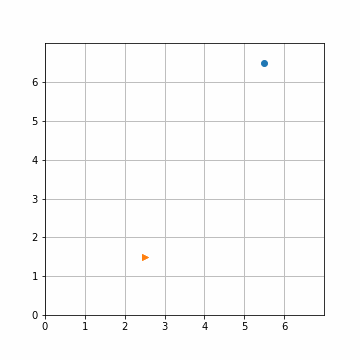

In [ ]:
#Simulate game with optimal policy
gif = simulate(policy_SARSA, 'simulation_SARSA', True)
gif